## Predictive Customer Analysis - 2

Following the descriptive analysis of the customer purchase on `Positioning_descriptive.ipynb` notebook, here logistic regression and linear regression will be applied will be performed to deepdive into purchase analysis and forecast.

This notebook continues the content of `Positioning_preditive.ipynb`, as it gets longer.

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression

import os 
import pickle

## Import the Data

In [2]:
def import_pickle_data(filename) :
    path = os.path.join(os.getcwd(), 'obj_data', filename)
    return pickle.load(open(path, 'rb')) #rb = read as byte datatype

def import_csv(filePath) :
    return pd.read_csv(filePath)

In [3]:
# loading the data file
filePath_purchase = os.path.join(os.getcwd(), 'data', 'purchase data.csv')
df_purchase = import_csv(filePath_purchase)

# importing classes
scaler = import_pickle_data('scaler.pickle')
pca = import_pickle_data('pca.pickle')
kmeans_pca = import_pickle_data('kmeans_pca.pickle')

# standardization
df_purchase.columns.values[-7:] # the 7 features standized 
features_to_include = df_purchase.columns.values[-7:]
df_purchase_std = scaler.transform(df_purchase[features_to_include])

# dimentionality reduction of the standardized data
df_purchase_pca = pca.transform(df_purchase_std)

# segmentation from the preprocessed data
segment_kmeans_pca = kmeans_pca.predict(df_purchase_pca)
df_purchase_analysis = df_purchase.copy()
df_purchase_analysis['Segment'] = segment_kmeans_pca

# binary encoding segment
segment_dummies = pd.get_dummies(df_purchase_analysis['Segment'], 
                                 prefix='Segment', prefix_sep='_')
df_purchase_analysis = pd.concat([df_purchase_analysis, segment_dummies], axis=1)

In [4]:
# Differentiate the dataframe for convenience
df_pa = df_purchase_analysis.copy()

In [5]:
df_pa.head(3)

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,47,1,110866,1,0,0,1,0,0,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,47,1,110866,1,0,0,1,0,0,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,47,1,110866,1,0,0,1,0,0,0


---
## `4.` Brand choice
Earlier, price elasticity was modeled and also when there is a promotion or not. The model had (purchase) `Incidence` as the only dependent variable against the `mean price` as X (predictor variable). 

In the study of brand choice, the logitic regression will also be used  to multiclass problems, i.e. with more than two possible **discrete** outcomes. [Wikipedia](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) explains  that it is a model that is used to predict the probabilities of the different possible outcomes of a categorically(equivalently nominally) distributed dependent variable with **more than two categories**, given **a set of independent variables** (which may be real-valued, binary-valued, categorical-valued, etc.).

In [6]:
df_pa['Brand'].unique() # be careful of 0  = no Incidence to rule out

array([0, 2, 5, 1, 4, 3])

In [7]:
brand_choice = df_pa.query('Incidence == 1').copy()
# brand_choice['Brand'].unique()

In [8]:
# Dependent variable (more than two categories) = Brand
Y = brand_choice['Brand']

In [9]:
# A set of indepent variables = Prices (real-valued)
X = brand_choice.loc[:, brand_choice.columns.str.contains('Price_')]

In [10]:
logit_brand_choice = LogisticRegression(solver='sag', multi_class='multinomial')

In [11]:
logit_brand_choice.fit(X, Y)

LogisticRegression(multi_class='multinomial', solver='sag')

In [12]:
logit_brand_choice.coef_

array([[-3.91594749,  0.65846631,  2.41775764,  0.7040935 , -0.20209691],
       [ 1.27462006, -1.87985168, -0.21261254, -0.20633501,  0.58787957],
       [ 1.62415282,  0.56208995,  0.50074262,  1.03947979,  0.45274562],
       [ 0.57454661,  0.395593  , -1.4005678 , -1.24623671,  0.24936261],
       [ 0.44262802,  0.26370241, -1.30531993, -0.29100156, -1.08789089]])

[Scikit Learn document](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) explains that `coef_` returns ndarray of (n_classes, n_features) where it corresponds to outcome 1 (True) and -coef_ corresponds to outcome 0 (False) for when `multi_class=multinomial`.

So rows represent Brands and columns represent Prices here, which will be transposed in the following :

In [13]:
coef_brand_choice = pd.DataFrame(logit_brand_choice.coef_.T)
coef_brand_choice.columns = ['Brand_' + str(i) for i in range(1, 6)]
coef_brand_choice.index = ['Price_' + str(i) for i in range(1, 6)]

In [14]:
coef_brand_choice

,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
Price_1,-3.915947,1.274620,1.624153,0.574547,0.442628
Price_2,0.658466,-1.879852,0.562090,0.395593,0.263702
Price_3,2.417758,-0.212613,0.500743,-1.400568,-1.305320
Price_4,0.704094,-0.206335,1.039480,-1.246237,-0.291002
Price_5,-0.202097,0.587880,0.452746,0.249363,-1.087891


### Insights
It is obvious that Price 1 has a negative coefficient vs choice of Brand 1 but the same relationship does not apply to Brand 3 (in which Price increases does not decrease the choice of Brand 3 - interesting!). 

For better insights, own price brand choice elasticity and cross price brand choice elasticity will be studied in the following sections.

### `4.1.` Own price elasticity - Brand 5

In [15]:
# Create a new range of price to predict PE (price elasticity)
price_range = np.arange(0.5, 3.5, 0.01)

In [16]:
# Creating a empty dataframe with the num_row equal to size of price range
df_own_brand_5 = pd.DataFrame(index=np.arange(price_range.size))

In [17]:
# Having other prices constant than price of Brand 5
df_own_brand_5['Price_1'] = brand_choice['Price_1'].mean()
df_own_brand_5['Price_2'] = brand_choice['Price_2'].mean()
df_own_brand_5['Price_3'] = brand_choice['Price_3'].mean()
df_own_brand_5['Price_4'] = brand_choice['Price_4'].mean()
df_own_brand_5['Price_5'] = price_range

In [18]:
# Brand choice in response to price range of Brand 5
predict_bc = logit_brand_choice.predict_proba(df_own_brand_5)
predict_bc.shape

(300, 5)

In [19]:
coef_brand_choice

,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
Price_1,-3.915947,1.274620,1.624153,0.574547,0.442628
Price_2,0.658466,-1.879852,0.562090,0.395593,0.263702
Price_3,2.417758,-0.212613,0.500743,-1.400568,-1.305320
Price_4,0.704094,-0.206335,1.039480,-1.246237,-0.291002
Price_5,-0.202097,0.587880,0.452746,0.249363,-1.087891


In [20]:
# Calculate own price elasticity 
beta_5 = coef_brand_choice.iloc[4,4]
PE_own_price_brand_5 = beta_5 * price_range * (1 - predict_bc[:,4])
PE_own_price_brand_5.shape

(300,)

In [21]:
brand_choice_elasticities = pd.DataFrame({'Price_point': price_range, 
                                          'Own_brand_5' : PE_own_price_brand_5})

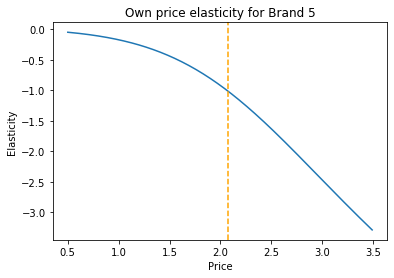

In [22]:
brand_choice_elasticities.plot(x='Price_point', y='Own_brand_5')

plt.title('Own price elasticity for Brand 5')
plt.ylabel('Elasticity')
plt.xlabel('Price')
plt.legend().remove() 
plt.axvline(x=2.07, ls='--', c='orange') # point of inelasticity 
plt.show()

In [23]:
#pd.options.display.max_rows = None
brand_choice_elasticities.iloc[150:160]

,Price_point,Own_brand_5
150,2.00,-0.922798
151,2.01,-0.934931
152,2.02,-0.947159
153,2.03,-0.959481
154,2.04,-0.971898
155,2.05,-0.984407
156,2.06,-0.997010
157,2.07,-1.009705
158,2.08,-1.022492
159,2.09,-1.035370


As price of own price increase, the choice for Brand 5 gradually gets more elastic. Brand 5 becomes elastic after the price point of 2.07, as the graph gets lightly steeper.

### `4.2.` Cross price elasticity - Brand 5, Cross Brand 4
How does the choice for Brand 5 changes as the price of Brand 4 changes, having all other brand prices constant at their means?

In [24]:
# Create a new range of price to predict PE (price elasticity)
price_range = np.arange(0.5, 3.5, 0.01) # 300 x 1 vector
df_cross_brand_4 = pd.DataFrame(index=np.arange(price_range.size))

In [25]:
df_cross_brand_4['Price_1'] = brand_choice['Price_1'].mean()
df_cross_brand_4['Price_2'] = brand_choice['Price_2'].mean()
df_cross_brand_4['Price_3'] = brand_choice['Price_3'].mean()
df_cross_brand_4['Price_4'] = price_range # only Brand 4 price changes within given range
df_cross_brand_4['Price_5'] = brand_choice['Price_5'].mean()

In [26]:
predict_bc_cross = logit_brand_choice.predict_proba(df_cross_brand_4)
predict_bc_cross.shape

(300, 5)

### Formula for Cross price elasticity :
$$𝐸𝑐𝑟𝑜𝑠𝑠 = −Beta(own product) ∗ Price(cross product) ∗ Purchase(cross product)$$

In [27]:
beta_brand_5 = coef_brand_choice.iloc[4,4] # beta of own product (Brand 5)
purchase_cross_4 = predict_bc_cross[:,3]

# Calculate PE 
PE_brand_5_cross_4 = -beta_brand_5 * price_range * purchase_cross_4

In [28]:
brand_choice_elasticities['Cross_4_brand_5'] = PE_brand_5_cross_4

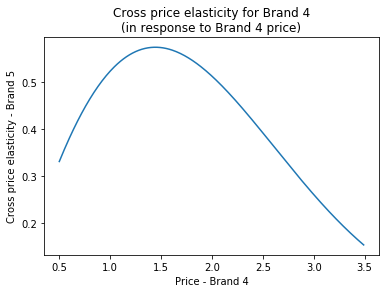

In [29]:
brand_choice_elasticities.plot(x='Price_point', y='Cross_4_brand_5')

plt.title('Cross price elasticity for Brand 4\n(in response to Brand 4 price)')
plt.xlabel('Price - Brand 4')
plt.ylabel('Cross price elasticity - Brand 5')
plt.legend().remove()
plt.show()

Cross price elasticity stays positive across the price range of Brand 4. When elasticity of cross brand > 0, it indicates that the cross brand is a **substitute**.

Although price elasiticty gets descreating after the price point of 1.5, but it still stays positive, meaning the purchase probability of Brand 5 still increases as Price of Brand 5 increases.

So when setting up a marketing strategy for Brand 5, targeting customers choosing Brand 4 to switch to Brand 5 makes sense. **But, it is a laborsome task to target all - therefore it is better off to perform a granular analysis of elasticity by segments.**

---
### `4.3.` Create a logit model function

The below functions may require refactoring when in production. However, here the code quality is not my primary focus so no refactoring is considered yet.

Create helper functions

In [84]:
def df_purchase_by_segment(segment_num, data=df_pa) :
    # Input : default to df_pa and well-off segment
    # Output : dataframe for a specific segment
    df = data.query('Incidence==1').copy()
    return df.query(f'Segment=={segment_num}')

def multi_logit_brand_choice(df) :
    # Output: fitted multinominal logit model
    # @columns : target variables(Y),  @rows : predictor variables(X)
    
    # Fit logit model     
    Y = df['Brand'] # Target variable
    X = df.loc[:, df.columns.str.contains('Price_')] # Predictors
    logit_brand_choice = LogisticRegression(solver='sag', 
                                            multi_class='multinomial',
                                            max_iter=300)
    return logit_brand_choice.fit(X, Y) # returns ndarray[classes Y, features X] 

def logit_coef_table(logit_model) :
    # Output : coef_ matrix transposed to generate
    return pd.DataFrame(logit_model.coef_.T, 
                        index=['Price_' + str(i) for i in range(1, 6)],
                        columns=['Brand_' + str(i) for i in range(1, 6)])

### Well-off

In [85]:
# Fit logit model
df_seg3 = df_purchase_by_segment(segment_num=3, data=df_pa) # well-off
model = multi_logit_brand_choice(df_seg3)
coef_tbl = logit_coef_table(model)

Own price brand choice elasticity

In [93]:
def own_price_elasticity(model, df, brand_num) : 
    # Output: own price brand choice elasticity    
    price_range = np.arange(0.5, 3.5, 0.01)
    price_tbl = pd.DataFrame(index=np.arange(price_range.size))

    price_tbl['Price_1'] = df['Price_1'].mean()
    price_tbl['Price_2'] = df['Price_2'].mean()
    price_tbl['Price_3'] = df['Price_3'].mean()
    price_tbl['Price_4'] = df['Price_4'].mean()
    price_tbl['Price_5'] = df['Price_5'].mean()
    
    if brand_num in [1,2,3,4,5]:
        price_tbl[f'Price_{brand_num}'] = price_range
    else: 
        print('brand_num must be one of [1,2,3,4,5]')
    
    purchase_pred = model.predict_proba(price_tbl)
    idx = brand_num - 1
    beta = coef_tbl.iloc[idx, idx]
    
    PE = beta * price_range * (1 - purchase_pred[:, idx])
    
    return pd.Series(PE, name=f'Own_brand_{brand_num}')

In [94]:
own_price_elasticity(model, df_seg3, brand_num=5)

0     -0.120788
1     -0.123240
2     -0.125696
3     -0.128156
4     -0.130621
         ...   
295   -1.348595
296   -1.353989
297   -1.359383
298   -1.364776
299   -1.370167
Name: Own_brand_5, Length: 300, dtype: float64

Cross price brand choice elasticity

In [71]:
def cross_price_elasticity(model, df, own_brand_num, cross_brand_num) : 
    # Output: cross price brand choice elasticity 
        
    price_range = np.arange(0.5, 3.5, 0.01)
    price_tbl = pd.DataFrame(index=np.arange(price_range.size))

    price_tbl['Price_1'] = df['Price_1'].mean()
    price_tbl['Price_2'] = df['Price_2'].mean()
    price_tbl['Price_3'] = df['Price_3'].mean()
    price_tbl['Price_4'] = df['Price_4'].mean()
    price_tbl['Price_5'] = df['Price_5'].mean()
    
    if cross_brand_num in [1,2,3,4,5]:
        price_tbl[f'Price_{cross_brand_num}'] = price_range
    else: 
        print('cross_brand_num must be one of [1,2,3,4,5]')
    
    purchase_pred = model.predict_proba(price_tbl)
    idx_own = own_brand_num - 1
    idx_cross = cross_brand_num - 1
    beta_own = coef_tbl.iloc[idx_own, idx_own]
    
    PE_cross = - beta_own * price_range * purchase_pred[:, idx_cross]
    
    return pd.Series(PE_cross, name=f'Cross_{cross_brand_num}_brand_{own_brand_num}')

In [76]:
def segment_classifier(seg_num) :   
    segment_dict = {0 : 'Fewer Opportunity', 
                    1 : 'Career Focused', 
                    2 : 'Standard', 
                    3 : 'Well off'}
    
    if(seg_num not in [0,1,2,3]) :
        print('Segment number must be one of [0, 1, 2, 3]')    
    else :
        return segment_dict[seg_num]

def brand_choice_price_elasticity_tbl(model, df, own_brand_num, cross_brand_num) :
    
    price_range = np.arange(0.5, 3.5, 0.01)
    price_series = pd.Series(price_range, name='Price_range')
    own_series = own_price_elasticity(model, df_seg3, own_brand_num)
    cross_series = cross_price_elasticity(model, df_seg3, own_brand_num, cross_brand_num)
    
    print('The table represents own and cross price brand choice elasticity')
    print(f'Own brand: Brand_{own_brand_num}')
    print(f'Cross brand: Brand_{cross_brand_num}')
    return pd.concat([price_series, own_series, cross_series], axis=1)

In [77]:
elasticity_tbl = brand_choice_price_elasticity_tbl(model, df_seg3, 5, 4)
elasticity_tbl # well_off, own Brand 5, cross Brand 4

The table represents own and cross price brand choice elasticity
Own brand: Brand_5
Cross brand: Brand_4


,Price_range,Own_brand_5,Cross_4_brand_5
0,0.50,-0.120796,0.195461
1,0.51,-0.123248,0.199231
2,0.52,-0.125705,0.202994
3,0.53,-0.128165,0.206750
4,0.54,-0.130630,0.210501
...,...,...,...
295,3.45,-1.348735,0.062141
296,3.46,-1.354130,0.059991
297,3.47,-1.359525,0.057907
298,3.48,-1.364918,0.055888
